https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values/notebook?scriptVersionId=28578470

## SHAP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Target variable: `median_house_value`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Missing Value Treatment

<Axes: xlabel='total_bedrooms'>

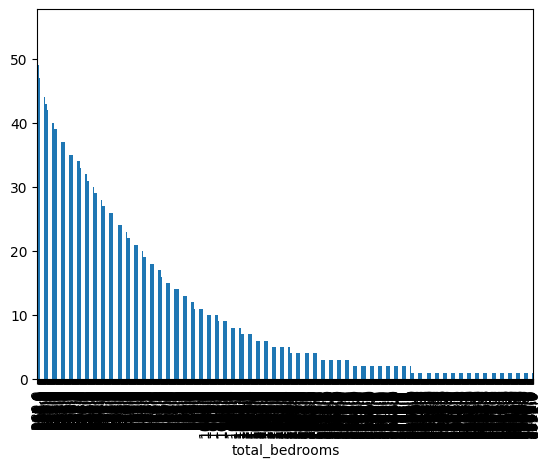

In [5]:
df['total_bedrooms'].value_counts().plot.bar()

The total_bedrooms distribution have skewed distribution. So, will use median to fill the missing values.

In [6]:
# Imputing missing value in total_bedrooms by median
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)

In [7]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Feature Vector and Target Variable

In [8]:
# Declare feature vector and target variable
X=df[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']]
y=df['median_house_value']

### Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Build the model

In [10]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

### Generate Predictions

In [11]:
y_pred=model.predict(X_test)

### Evaluating Performance

In [12]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_test, y_pred)**(0.5)
mse

68126.3666645792

### SHAP Explanation Force Plots

- We use SHAP to explain individual predictions.
    - Use fast `TreeSHAP` estimation instead of `KernelSHAP` method, since a random forest is an ensemble of trees.

In [13]:
import shap

# Model's prediction using SHAP
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(X_train)

# Visualize the prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])

Interpretation:
- Plot shows features contributing to push the model output from the base value (the average model output over the training dataset we passed) to model output.
- Features in:
    - `Red` : Pushing the predictions higher
    - `Blue` : Pushing the predictions lower

- Pushing prediction:
    - Higher: housing_median_age
    - Lower: median_income, latitude and longitude

- Base value of median_house_value is 2.063e+5 = 206300
- Output value is 70189.83 with 
    - housing_median_age = 52
    - median_income = 1.975
    - latitude = 36.73
    - longitude = -119.8

In [14]:
# Visualize the training set predictions
# shap.force_plot(explainer.expected_value, shap_values, X_train)

### SHAP Feature Importance

- Idea behind SHAP feature importance:
    - Features with large absolute Shapley values are important.
    - Since we want global importance, we average absolute Shapley value per feature across the data

- Then we sort the features by decreasing importance and plot them.

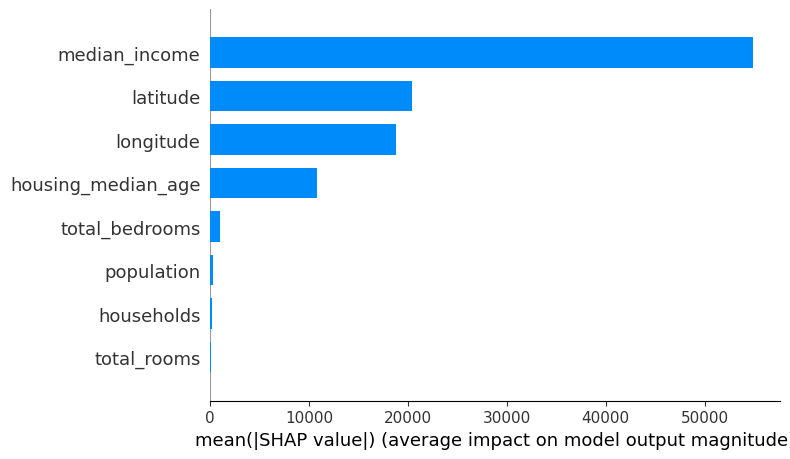

In [15]:
shap_values=shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

- SHAP feature importance measured as the mean absolute Shapley values.
- Variables:
    - `median_income` ws the most important feature, changing the predicted
    - `median_house_value` on average by 56k on x-axis

### Shap Summary Plot

- Combines:
    - Feature importance with feature effects.
    - Each point on a summary plot is a Shapley value for a feature and an instance.
    - Position
        - on y-axis is determined by: feature
        - on x-axis by Shapley value

- Colour represents the value of the feature from low to high.
- Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of Shapley values per feature, where feature are ordered according to their importance


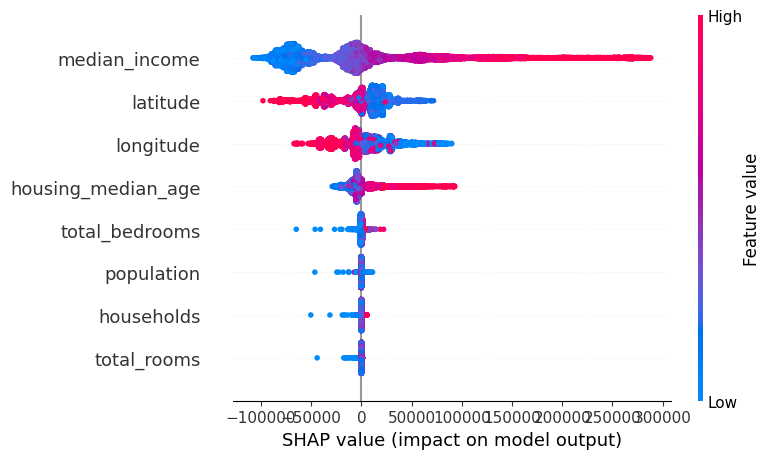

In [16]:
shap.summary_plot(shap_values, X_train)

SHAP Summary plot:
    - Combines feature importance with feature effects.

Each point on summary plot is a Shapley value for a feature and an instance.
- Position on:
    - x-axis: by shapley value
    - y-axis: determined by the feature

- Colors: Value of feature from low to high.
- Overlapping points are jittered in y-axis direction, gives sense of distribution of Shapley vlaue per feature.
- Feature ordered according to their importance.

- This plot is made of all the dots in the train data. It demonstrates the following information:
    - Feature importance: Variables are ranked in descending order.
    - Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
    - Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
    - Correlation: A high level of the median_income has a high and positive impact on the median_house_value. 
        -  The “high” comes from the red color, and the “positive” impact is shown on the X-axis.

- `housing_median_age` is positively correlated with the target variable median_house_value.

### SHAP Dependence Plot

- This plot shows marginal effect one or two features have on the predicted outcome of ML model it tells whether the relationship between the target and feature is:
    - `linear`, `monotonic` or more complex

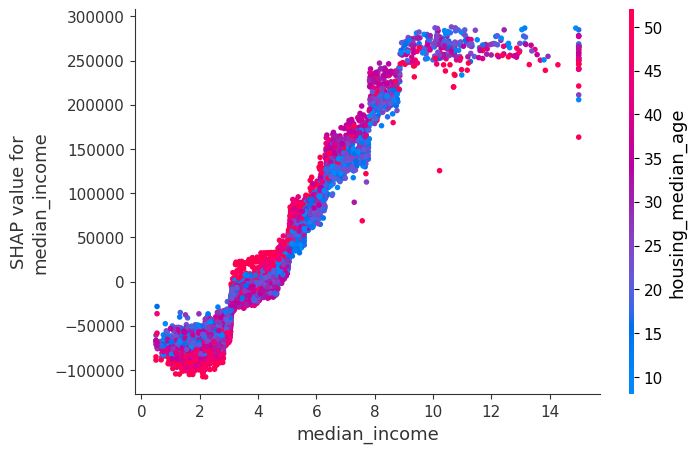

In [17]:
shap.dependence_plot('median_income', shap_values, X_train)

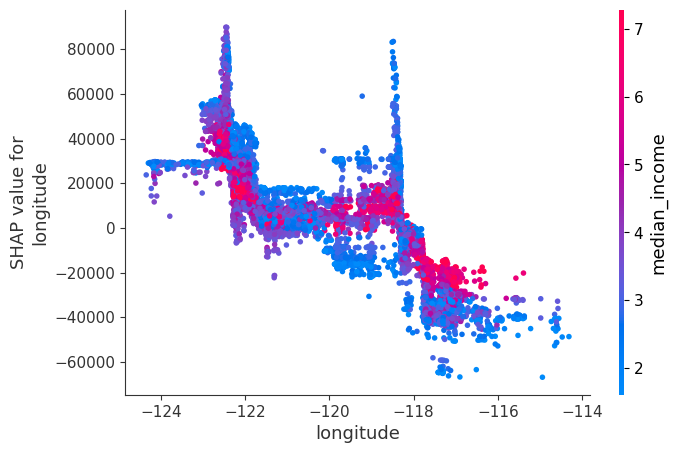

In [19]:
shap.dependence_plot('longitude', shap_values, X_train)